In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'finding-lungs-in-ct-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1172%2F2106%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240328%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240328T065852Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4f41a84e40501900883a511e440ea79462ee37e8d1943ff3c9dd76a320a0aa5ddb1c36f9267e7949d7d89f34729d7a81b12bd8a71148cbd978dd40196f61a2c7538aff55ef3875fcc71ee96355a7054457733f75c495051fcb082910202e11dce541e84e022b93af05fa8f83cbdbd7aefeef8ab6da7be70c706f3aa870a20015d625bd03d17e8a68557d9481611c39f3c69c621b046abf6a389e92e352025cbd5a4bb1d58bf9e41eb09246bc40d68dd1c65fff41ce380775dee64eb2b4330d44e3228379eed4b8976364cb16daabfa999943b3cee02452560813879194e0e0fce039af03c707e924f742edccdf817943eb2ea8b0081ad87fd74ed14802fe56b9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1108422436 bytes downloaded
Downloaded and uncompressed: finding-lungs-in-ct-data
Data source import complete.


In [2]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00


In [3]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array

from sklearn.model_selection import train_test_split

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Segmentation Models: using `tf.keras` framework.


## Extract Data

In [4]:
def Extract_Data(filepath, name):
  with zipfile.ZipFile(file=filepath) as file:
    file.extractall(os.path.join(os.getcwd(), name))

In [5]:
Extract_Data("/kaggle/input/finding-lungs-in-ct-data/2d_images.zip", "2d_images")
Extract_Data("/kaggle/input/finding-lungs-in-ct-data/2d_masks.zip", "2d_masks")

In [6]:
image_dir = "/content/2d_images"
mask_dir = "/content/2d_masks"

In [59]:
image_reader = lambda x: np.expand_dims(cv2.imread(x, cv2.IMREAD_GRAYSCALE)[::4, ::4], axis=-1)

In [60]:
image_path = [os.path.join(image_dir, i) for i in sorted(os.listdir(image_dir))]
mask_path = [os.path.join(mask_dir, i) for i in sorted(os.listdir(mask_dir))]

## EDA

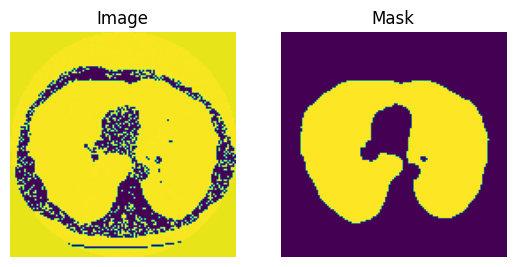

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(image_reader(image_path[1]))
ax[0].set_title("Image")
ax[0].axis("off")

ax[1].imshow(image_reader(mask_path[1]))
ax[1].set_title("Mask")
ax[1].axis("off")

plt.show()

In [62]:
loaded_images = np.stack([image_reader(i) for i in image_path])/255
loaded_masks = np.stack([image_reader(i) for i in mask_path])/255

print(len(loaded_images))

267


## SPLIT DATA

In [63]:
Xtrain, Xtest, ytrain, ytest = train_test_split(loaded_images, loaded_masks, test_size=.001)

print(Xtrain.shape, Xtest.shape)

(266, 128, 128, 1) (1, 128, 128, 1)


In [64]:
input_layer = keras.Input(shape=Xtrain.shape[1:], name="Input_Layer")
x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(input_layer)
x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(x)
x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Dense(units=126, activation="relu")(x)
x = keras.layers.Conv2D(filters=1, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(x)
model_output = keras.layers.UpSampling2D(size=(2, 2))(x)

model = keras.Model(inputs=input_layer, outputs=model_output)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 dense_2 (Dense)             (None, 64, 64, 126)       16254     
                                                           

In [65]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy"])

In [66]:
history = model.fit(Xtrain, ytrain,
                    validation_split=.1,
                    batch_size=32,
                    epochs=20,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy"),
                              keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", min_lr=1e-5, patience=2)])

Epoch 1/20
8/8 [==============================] - 12s 687ms/step - loss: 0.7607 - accuracy: 0.7381 - val_loss: 0.5171 - val_accuracy: 0.7502 - lr: 0.0010
Epoch 2/20
8/8 [==============================] - 1s 85ms/step - loss: 0.5001 - accuracy: 0.7661 - val_loss: 0.4870 - val_accuracy: 0.7502 - lr: 0.0010
Epoch 3/20
8/8 [==============================] - 1s 85ms/step - loss: 0.4751 - accuracy: 0.7661 - val_loss: 0.7390 - val_accuracy: 0.5014 - lr: 0.0010
Epoch 4/20
8/8 [==============================] - 1s 86ms/step - loss: 0.6721 - accuracy: 0.5276 - val_loss: 0.5949 - val_accuracy: 0.6226 - lr: 1.0000e-04
Epoch 5/20
8/8 [==============================] - 1s 86ms/step - loss: 0.5708 - accuracy: 0.7063 - val_loss: 0.5420 - val_accuracy: 0.7502 - lr: 1.0000e-04
Epoch 6/20
8/8 [==============================] - 1s 86ms/step - loss: 0.5378 - accuracy: 0.7661 - val_loss: 0.5382 - val_accuracy: 0.7502 - lr: 1.0000e-05


## Trying a differen image reader

In [73]:
image_reader_ = lambda x: img_to_array(load_img(x, color_mode="grayscale"))[::4, ::4]

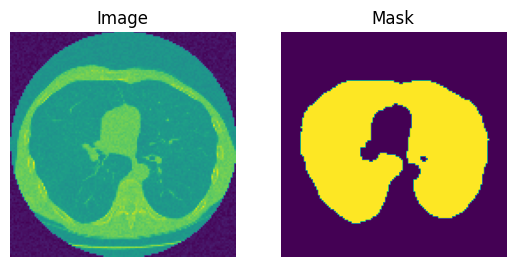

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(image_reader_(image_path[1]))
ax[0].set_title("Image")
ax[0].axis("off")

ax[1].imshow(image_reader_(mask_path[1]))
ax[1].set_title("Mask")
ax[1].axis("off")

plt.show()

In [75]:
loaded_images_ = np.stack([image_reader_(i) for i in image_path])/255
loaded_masks_ = np.stack([image_reader_(i) for i in mask_path])/255

print(len(loaded_images_))

267


In [76]:
Xtrain_, Xtest_, ytrain_, ytest_ = train_test_split(loaded_images_, loaded_masks_, test_size=.001)

print(Xtrain_.shape, Xtest_.shape)

(266, 128, 128, 1) (1, 128, 128, 1)


In [77]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy"])

In [78]:
model.fit(Xtrain_, ytrain_,
          validation_split=.1,
          batch_size=32,
          epochs=20,
          callbacks=[keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy"),
                              keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", min_lr=1e-5, patience=2)])

Epoch 1/20
8/8 [==============================] - 2s 127ms/step - loss: 3.5254 - accuracy: 0.7382 - val_loss: 3.5070 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 2/20
8/8 [==============================] - 1s 83ms/step - loss: 3.6483 - accuracy: 0.7635 - val_loss: 3.5070 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 3/20
8/8 [==============================] - 1s 83ms/step - loss: 3.6483 - accuracy: 0.7635 - val_loss: 3.5070 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 4/20
8/8 [==============================] - 1s 83ms/step - loss: 3.6483 - accuracy: 0.7635 - val_loss: 3.5070 - val_accuracy: 0.7726 - lr: 1.0000e-04
Epoch 5/20
8/8 [==============================] - 1s 83ms/step - loss: 3.6483 - accuracy: 0.7635 - val_loss: 3.5070 - val_accuracy: 0.7726 - lr: 1.0000e-04
Epoch 6/20
8/8 [==============================] - 1s 83ms/step - loss: 3.6483 - accuracy: 0.7635 - val_loss: 3.5070 - val_accuracy: 0.7726 - lr: 1.0000e-05


In [79]:
image_generator = keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
                                                               height_shift_range=0.1,
                                                               rotation_range=45,
                                                               zoom_range=0.1)

In [98]:
Xtrain, Xtest, ytrain, ytest = train_test_split(loaded_images_, loaded_masks, test_size=.1)

print(Xtrain.shape, Xtest.shape)

(240, 128, 128, 1) (27, 128, 128, 1)


In [99]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy"])

In [100]:
model.fit(image_generator.flow(Xtrain, ytrain),
          validation_data=(image_generator.flow(Xtest, ytest)),
          batch_size=32,
          epochs=100,
          callbacks=[keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy"),
                              keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", min_lr=1e-5, patience=2)])

Epoch 1/100
8/8 [==============================] - 6s 570ms/step - loss: 0.5146 - accuracy: 0.7498 - val_loss: 0.4794 - val_accuracy: 0.7612 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 1s 95ms/step - loss: 0.4797 - accuracy: 0.7646 - val_loss: 0.4532 - val_accuracy: 0.7616 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 1s 93ms/step - loss: 0.4714 - accuracy: 0.7649 - val_loss: 0.4448 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 1s 93ms/step - loss: 0.4542 - accuracy: 0.7645 - val_loss: 0.4207 - val_accuracy: 0.7643 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 1s 95ms/step - loss: 0.4449 - accuracy: 0.7651 - val_loss: 0.4279 - val_accuracy: 0.7634 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 1s 94ms/step - loss: 0.4387 - accuracy: 0.7679 - val_loss: 0.4228 - val_accuracy: 0.7603 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 1s 95ms/step - loss: 0.4334 - 

In [96]:
Xtest_[0].shape

(128, 128, 1)

1/1 [==============================] - 0s 36ms/step


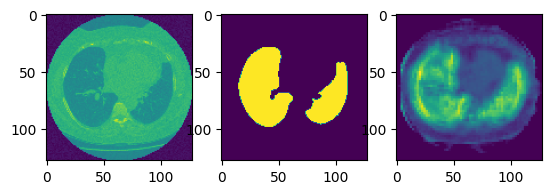

In [111]:
plt.subplot(1, 3, 1)
plt.imshow(Xtest[2])
plt.subplot(1, 3, 2)
plt.imshow(ytest[2])
plt.subplot(1, 3, 3)
plt.imshow(model.predict(np.expand_dims(Xtest[2], axis=0)).reshape(128, 128, 1)/255)

## Eddy